converted from BO3parameter_v2_physics_based.py
-updated 01/18/26 by gemini to integrate measurement instruments
while the first version is only equipped with sim-data-generation without real meas
-v2; backtunneling model corrected 
"""
양자 전류 플래토 탐색을 위한 베이지안 최적화 (V2 - Physics-Based)
Bayesian Optimization for Quantum Current Plateau Search

Based on: Bae et al., Metrologia 57 (2020) 065025
"Precision measurement of single-electron current with quantized Hall
array resistance and Josephson voltage"

개선 사항 (V2):
1. Back-tunneling 물리 모델 기반 시뮬레이션
2. 실측 데이터 기반 피팅 파라미터 (α, β, γ, δ, ε, ζ)
3. KRISS 논문 Figure 3(b) 스타일 |δIp| 플롯
4. 플래토 영역 매핑 및 시각화
5. Matérn 5/2 커널 + Expected Improvement
6. 조기 종료 및 데이터 로깅

Author: Claude (Anthropic) converted to ipynb by gemini
Date: 2025-01-14
Reference: Metrologia 57 (2020) 065025
"""

In [1]:
# 1. IMPORTS & SETUP
import numpy as np
import time
import json
import csv
import warnings
from datetime import datetime
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from IPython.display import clear_output, display

# Analysis & Optimization
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.optimize import minimize, curve_fit
from scipy.stats import norm

# Hardware Control
import pyvisa

# Notebook specific settings
%matplotlib inline
warnings.filterwarnings("ignore")

print("Libraries loaded successfully.")


Libraries loaded successfully.


In [2]:
# 2. CONFIGURATION & PHYSICS MODEL
class Config:
    e = 1.602176634e-19    # Elementary charge (C)
    h = 6.62607015e-34     # Planck constant
    f = 0.350540506e9      # 0.35 GHz
    
    @property
    def target_current(self):
        return self.e * self.f
    
    # GPIB Addresses
    addr_yoko_ent  = "GPIB0::11::INSTR"
    addr_yoko_p    = "GPIB0::7::INSTR"
    addr_yoko_exit = "GPIB0::8::INSTR"
    addr_dmm       = "GPIB0::22::INSTR"
    
    # Gate Voltage Bounds [V_ENT, V_P, V_EXIT]
    bounds = np.array([
        [-0.70, -0.55],
        [-0.70, -0.58],
        [-0.70, -0.62]
    ])
    
    # BO Settings
    n_initial_points = 20
    n_iterations = 80
    acquisition_type = "EI"
    kappa = 2.5
    xi = 0.01
    
    # Experiment Settings
    early_stop_patience = 20
    early_stop_threshold = 1e-5
    log_dir = Path("./experiment_logs")
    experiment_name = f"BO_plateau_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    settling_time = 0.15
    n_measurements = 5

class BackTunnelingModel:
    """
    User Proposed Physics Model: Multiplicative Factors
    <n> ~ f(V_exit) * f(V_p) * f(V_ent)
    """
    
    def __init__(self):
        # 1. Exit Gate Parameters (V_EXIT)
        # Bounds: [-0.70, -0.62]
        self.alpha_exit = 60.0; self.beta_exit = 180.0
        self.V1_exit = -0.64    # Plateau Start (Turn-on)
        self.V2_exit = -0.69    # Plateau End (Error onset)
        
        # 2. Plunger Gate Parameters (V_P)
        # Bounds: [-0.70, -0.58]
        self.gamma_p = 50.0; self.delta_p = 150.0
        self.V3_p = -0.60       # Plateau Start
        self.V4_p = -0.68       # Plateau End
        
        # 3. Entrance Gate Parameters (V_ENT)
        # Bounds: [-0.70, -0.55]
        self.epsilon_ent = 40.0; self.zeta_ent = 120.0
        self.V5_ent = -0.58     # Plateau Start
        self.V6_ent = -0.66     # Plateau End
        
        self.noise_std = 1e-7   # Noise Level
    
    def plateau_factor(self, V, alpha, beta, V_start, V_end):
        """
        Generates a bathtub shape:
        - Rises to 1 near V_start
        - Stays at 1
        - Deviates (Back-tunneling) near V_end
        """
        # Note: Depending on the physics sign convention, 
        # V_start could be the less negative or more negative value.
        # Here we assume the standard form:
        # 1 - exp(-alpha * (V - V_start)) : Turn on
        # + exp(beta * (V - V_end))       : Error/Leakage
        
        term1 = 1.0 - np.exp(-alpha * (V - V_start))
        term2 = np.exp(beta * (V - V_end))
        return term1 + term2
    
    def calculate_n_avg(self, V_ent, V_p, V_exit):
        # Calculate factor for each gate
        n_exit = self.plateau_factor(V_exit, self.alpha_exit, self.beta_exit, self.V1_exit, self.V2_exit)
        n_p    = self.plateau_factor(V_p,    self.gamma_p,    self.delta_p,    self.V3_p,    self.V4_p)
        n_ent  = self.plateau_factor(V_ent,  self.epsilon_ent, self.zeta_ent,  self.V5_ent,  self.V6_ent)
        
        # Multiplicative combination (ALL gates must be in plateau range)
        n_avg = n_exit * n_p * n_ent
        
        # Add measurement noise
        return n_avg + np.random.normal(0, self.noise_std)
    
    def calculate_current(self, V_ent, V_p, V_exit, config):
        n_avg = self.calculate_n_avg(V_ent, V_p, V_exit)
        return n_avg * config.e * config.f

In [3]:
# 3. UTILITY CLASSES
class DataLogger:
    def __init__(self, config):
        self.cfg = config
        self.log_dir = config.log_dir / config.experiment_name
        self.log_dir.mkdir(parents=True, exist_ok=True)
        self.csv_path = self.log_dir / "measurements.csv"
        with open(self.csv_path, 'w', newline='') as f:
            csv.writer(f).writerow(['iter', 'time', 'V_ENT', 'V_P', 'V_EXIT', 'I_A', 'I_pA', 'n_avg', 'delta_Ip', 'cost', 'phase'])
    
    def log(self, *args):
        with open(self.csv_path, 'a', newline='') as f:
            csv.writer(f).writerow([*args])

class InstrumentController:
    def __init__(self, config, physics_model=None):
        self.cfg = config
        self.physics_model = physics_model or BackTunnelingModel()
        self.sim_mode = False # 기본은 실측 모드 시도
        
        try:
            self.rm = pyvisa.ResourceManager()
            
            # 1. 장비 연결 시도 (주소는 Config에 정의됨)
            self.yoko_ent = self.rm.open_resource(self.cfg.addr_yoko_ent)
            self.yoko_p = self.rm.open_resource(self.cfg.addr_yoko_p)
            self.yoko_exit = self.rm.open_resource(self.cfg.addr_yoko_exit)
            self.dmm = self.rm.open_resource(self.cfg.addr_dmm)
            
            # 2. DMM 초기 설정 (실제 장비에 맞는 설정 명령어를 보내야 함)
            # 예시 설정입니다. 실제 장비 매뉴얼에 맞춰 수정이 필요할 수 있습니다.
            self.dmm.write_termination = '\n'; self.dmm.read_termination = '\n'
            self.dmm.write("*RST"); self.dmm.write("*CLS")
            self.dmm.write(":SENS:FUNC 'CURR:DC'")
            self.dmm.write(":SENS:CURR:DC:RANG:AUTO ON")
            self.dmm.write(":TRIG:SOUR IMM")
            
            print("✅ Instruments connected (Real Mode)")
            
        except Exception as e:
            # 연결 실패 시 시뮬레이션 모드로 전환
            print(f"⚠️ Connection failed: {e}")
            print("⚠️ Switching to Simulation Mode")
            self.sim_mode = True
    
    def set_voltages(self, v_ent, v_p, v_exit):
        """전압 인가"""
        if not self.sim_mode:
            # 실제 장비에 전압 설정 명령 전송
            self.yoko_ent.write(f'S{v_ent:.5f}E')
            self.yoko_p.write(f'S{v_p:.5f}E')
            self.yoko_exit.write(f'S{v_exit:.5f}E')
            time.sleep(self.cfg.settling_time) # 전압 안정화 대기
        else:
            # 시뮬레이션 모드에서는 아무것도 안 함 (혹은 딜레이만 줌)
            pass
        
    def measure_current(self, v_ent, v_p, v_exit):
        """전류 측정"""
        if self.sim_mode:
            # 시뮬레이션 데이터 반환
            return self.physics_model.calculate_current(v_ent, v_p, v_exit, self.cfg)
        else:
            # 실제 DMM 데이터 읽기 (누락되었던 부분!)
            try:
                values = []
                for _ in range(self.cfg.n_measurements):
                    self.dmm.write(":INIT")
                    time.sleep(0.05) # 측정 대기
                    val = float(self.dmm.query(":FETCH?"))
                    values.append(val)
                return np.mean(values) # 평균값 반환
            except Exception as e:
                print(f"Measurement Error: {e}")
                return 0.0

class BayesianOptimizer:
    def __init__(self, bounds, acquisition_type='EI', kappa=2.5, xi=0.01):
        self.bounds = bounds; self.xi = xi
        kernel = C(1.0) * Matern(length_scale=[0.05]*3, nu=2.5) + WhiteKernel(noise_level=1e-6)
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, normalize_y=True)
        self.y_best = np.inf
    
    def fit(self, X, y):
        self.gp.fit(X, y)
        self.y_best = np.min(y)
    
    def suggest(self):
        X_rnd = np.random.uniform(self.bounds[:,0], self.bounds[:,1], size=(2000, 3))
        mu, sigma = self.gp.predict(X_rnd, return_std=True)
        imp = self.y_best - mu - self.xi
        Z = imp / np.maximum(sigma, 1e-10)
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        return X_rnd[np.argmax(ei)]

class EarlyStopping:
    def __init__(self, patience=20):
        self.patience = patience; self.best = np.inf; self.cnt = 0
    def update(self, cost):
        if cost < self.best - 1e-5: self.best = cost; self.cnt = 0
        else: self.cnt += 1
        return self.cnt >= self.patience


In [4]:
# 4. VISUALIZATION (Jupyter Optimized)
class JupyterVisualizer:
    def __init__(self, config):
        self.data = {'V': [], 'n': [], 'd': []}
        
    def update_data(self, v, n, d):
        self.data['V'].append(v); self.data['n'].append(n); self.data['d'].append(np.abs(d))

    def plot(self, costs, X):
        V = np.array(self.data['V']); d = np.array(self.data['d'])
        if len(V) == 0: return
        
        fig = plt.figure(figsize=(15, 6))
        gs = gridspec.GridSpec(1, 3)
        
        # 1. Plateau
        ax1 = fig.add_subplot(gs[0])
        ax1.scatter(V, -np.array(self.data['n']), c='g', alpha=0.5)
        ax1.set_title('Current Plateau'); ax1.grid(True)
        
        # 2. Delta (Log)
        ax2 = fig.add_subplot(gs[1])
        ax2.semilogy(V, d, 'k.', alpha=0.5)
        ax2.axhline(1e-6, c='g', ls='--')
        ax2.set_title('|δIp| (Log scale)'); ax2.grid(True)
        
        # 3. Cost
        ax3 = fig.add_subplot(gs[2])
        ax3.plot(costs, 'o-', c='teal')
        ax3.set_title('Optimization Cost'); ax3.grid(True)
        
        plt.tight_layout()
        clear_output(wait=True)
        display(fig)
        plt.close(fig)


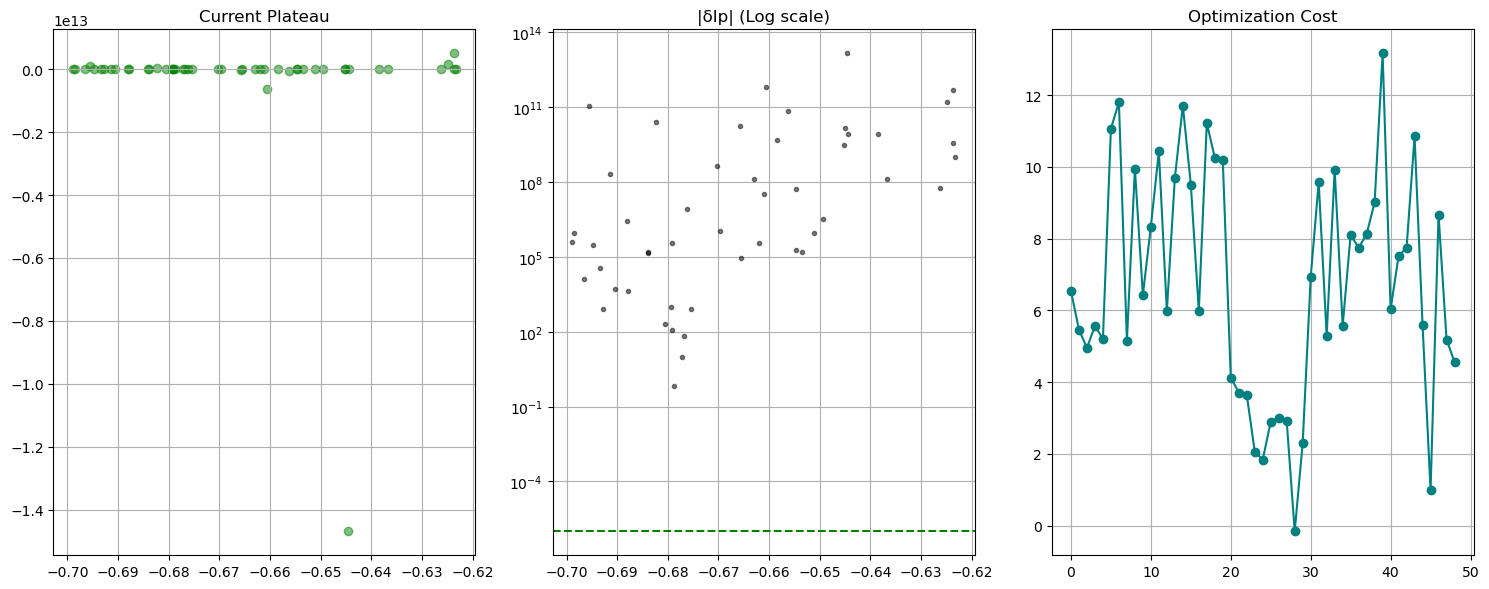

Early Stopping!


In [5]:
# 5. MAIN EXECUTION
def run_experiment():
    cfg = Config()
    instr = InstrumentController(cfg)
    bo = BayesianOptimizer(cfg.bounds)
    logger = DataLogger(cfg)
    viz = JupyterVisualizer(cfg)
    stop = EarlyStopping()
    
    X_hist, y_hist = [], []
    
    print("Starting Optimization...")
    
    for i in range(cfg.n_initial_points + cfg.n_iterations):
        phase = 'INIT' if i < cfg.n_initial_points else 'BO'
        
        if phase == 'INIT': x_next = np.random.uniform(cfg.bounds[:,0], cfg.bounds[:,1])
        else:
            bo.fit(X_hist, y_hist)
            x_next = bo.suggest()
            
        cur = instr.measure_current(*x_next)
        n_avg = cur / cfg.target_current
        delta = n_avg - 1
        cost = np.log10(np.abs(delta) + 1e-15)
        
        X_hist.append(x_next); y_hist.append(cost)
        logger.log(i, datetime.now(), *x_next, cur, cur*1e12, n_avg, delta, cost, phase)
        viz.update_data(x_next[2], n_avg, delta)
        
        if i % 2 == 0: viz.plot(y_hist, X_hist)
        
        if phase == 'BO' and stop.update(cost):
            print("Early Stopping!"); break
            
    return X_hist, y_hist

# Run
X, y = run_experiment()
